**Author**: Thiago Ribas Bella

**Date**: 07-February-2024

**Linkedin**: https://www.linkedin.com/in/trbella92/

**Github**: https://github.com/trbella

#**Hotel Customer Data Analysis and Cancellation Prediction**

**Goal of this notebook**:

Analyze a dataset of hotel customers and investigate the data to uncover insights that can assist the company in preventing cancellations. Additionally, build a predictive model capable of anticipating cancellations, enabling the company to take timely retention actions.

Trough this notebook, I will address the following questions:

**a)** Develop hypotheses and visualizations involving the 'cancellation' variable and at least two other variables present in the dataset.

**b)** Develop a predictive classification model to identify cancellations and use appropriate metrics to argue the effectiveness of the model.

**c)** When performing cross-validation of the classification model, discuss the differences between using random train-test splits and temporal splits (e.g., training in 2015 and 2016 and validating in 2017). Are the results different? Which approach is more recommended?

##**Installing libraries**

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
!pip install catboost

##**Load Libraries**

In [19]:
# Libraries
import pandas as pd
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import numpy as np

import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    TimeSeriesSplit,
)

from imblearn.over_sampling import SMOTENC

import warnings
import shap
import joblib

#Gradient Boosting
import catboost
from catboost import *
from catboost import CatBoostClassifier

from google.colab import drive
from google.colab import files

# Additional Setup
warnings.filterwarnings('ignore')
drive.mount('/content/drive', force_remount=True)

##**Load dataset**

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/DHAUZ/processo_seletivo/dataset/cancellation_prediction.csv',header=0,sep=',')
print(f'dataset shape:\n{dataset.shape}')
dataset.head(5)

dataset shape:
(119390, 28)


,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.0,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.0,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.0,0,1


##**Dataset exploration**

In [7]:
#Check columns names
dataset.columns

Index(['type', 'cancellation', 'days_between_booking_arrival',
       'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'country', 'market_segment', 'distribution_channel',
       'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
       'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
       'id_travel_agency_booking', 'id_person_booking', 'customer_type',
       'avg_price', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

In [8]:
# Check unique values for each variable
for column in dataset.columns:
    unique_values = dataset[column].unique()
    print(f"Unique values for '{column}': {unique_values}\n")

Unique values for 'type': ['Fancy Hotel' 'Hotel']

Unique values for 'cancellation': [0 1]

Unique values for 'days_between_booking_arrival': [342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 18

In [9]:
# Check the number of NaN values for each variable
for column in dataset.columns:
    nan_count = dataset[column].isnull().sum()/len(dataset)*100
    print(f"Number of NaN values in '{column}': {round(nan_count,2)}%\n")

Number of NaN values in 'type': 0.0%

Number of NaN values in 'cancellation': 0.0%

Number of NaN values in 'days_between_booking_arrival': 0.0%

Number of NaN values in 'year_arrival_date': 0.0%

Number of NaN values in 'month_arrival_date': 0.0%

Number of NaN values in 'week_number_arrival_date': 0.0%

Number of NaN values in 'day_of_month_arrival_date': 0.0%

Number of NaN values in 'num_weekend_nights': 0.0%

Number of NaN values in 'num_workweek_nights': 0.0%

Number of NaN values in 'num_adults': 0.0%

Number of NaN values in 'num_children': 0.0%

Number of NaN values in 'num_babies': 0.0%

Number of NaN values in 'breakfast': 0.0%

Number of NaN values in 'country': 0.41%

Number of NaN values in 'market_segment': 0.0%

Number of NaN values in 'distribution_channel': 0.0%

Number of NaN values in 'repeated_guest': 0.0%

Number of NaN values in 'num_previous_cancellations': 0.0%

Number of NaN values in 'num_previous_stays': 0.0%

Number of NaN values in 'reserved_room': 0.0%

N

**Observations**: The variables with the most NaN values are:

- id_person_booking, with 94.31% of the data missing.
- id_travel_agency_booking, with 13.69% of the data missing.

However, since these variables aren't particularly relevant for the analysis, this issue shouldn't pose a problem.

In [10]:
# Check data types for each variable
for column in dataset.columns:
    data_type = dataset[column].dtype
    print(f"Data type for '{column}': {data_type}")

Data type for 'type': object
Data type for 'cancellation': int64
Data type for 'days_between_booking_arrival': int64
Data type for 'year_arrival_date': int64
Data type for 'month_arrival_date': object
Data type for 'week_number_arrival_date': int64
Data type for 'day_of_month_arrival_date': int64
Data type for 'num_weekend_nights': int64
Data type for 'num_workweek_nights': int64
Data type for 'num_adults': int64
Data type for 'num_children': float64
Data type for 'num_babies': int64
Data type for 'breakfast': bool
Data type for 'country': object
Data type for 'market_segment': int64
Data type for 'distribution_channel': int64
Data type for 'repeated_guest': int64
Data type for 'num_previous_cancellations': int64
Data type for 'num_previous_stays': int64
Data type for 'reserved_room': object
Data type for 'changes_between_booking_arrival': int64
Data type for 'deposit_policy': object
Data type for 'id_travel_agency_booking': float64
Data type for 'id_person_booking': float64
Data type 

**Observations**: This dataset seems quite clean. For analytical purposes, certain categorical variables should be transformed into the category type

In [11]:
# List of columns to convert to categorical
columns_to_convert = ['market_segment', 'distribution_channel', 'id_travel_agency_booking', 'id_person_booking', 'customer_type']

# Convert columns to categorical
dataset[columns_to_convert] = dataset[columns_to_convert].astype('category')


In [12]:
#reordering the dataset
desired_order = ['cancellation', 'type', 'days_between_booking_arrival',
                 'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
                 'day_of_month_arrival_date', 'num_weekend_nights',
                 'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
                 'breakfast', 'country', 'market_segment', 'distribution_channel',
                 'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
                 'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
                 'id_travel_agency_booking', 'id_person_booking', 'customer_type',
                 'avg_price', 'required_car_parking_spaces',
                 'total_of_special_requests']

# Reorder the columns
dataset = dataset[desired_order]

In [13]:
#target variable balance
print('Sample size: ',len(dataset))
print('Number of explanatory variables: ',len(dataset.columns)-1)
print('\nLabel frequencies')
print('cancellations:')
print(dataset['cancellation'].value_counts())

Sample size:  119390
Number of explanatory variables:  27

Label frequencies
cancellations:
0    75166
1    44224
Name: cancellation, dtype: int64


**Observation**: The target variable is unbalanced. It will likely need balancing with SMOTE, but I will check this later.

##**Pandas profilling for insights**

In [14]:
# running pandas profilling for insights
profile = ProfileReport(dataset, title='profilling_report', html={'style':{'full_width':True}})
profile

In [15]:
# Save the report to a file
profile.to_file("profiling_report.html")

# Trigger the download of the HTML file
files.download("profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**The profilling_report.html is in the github directory**

##**Correlations (Pearson)**

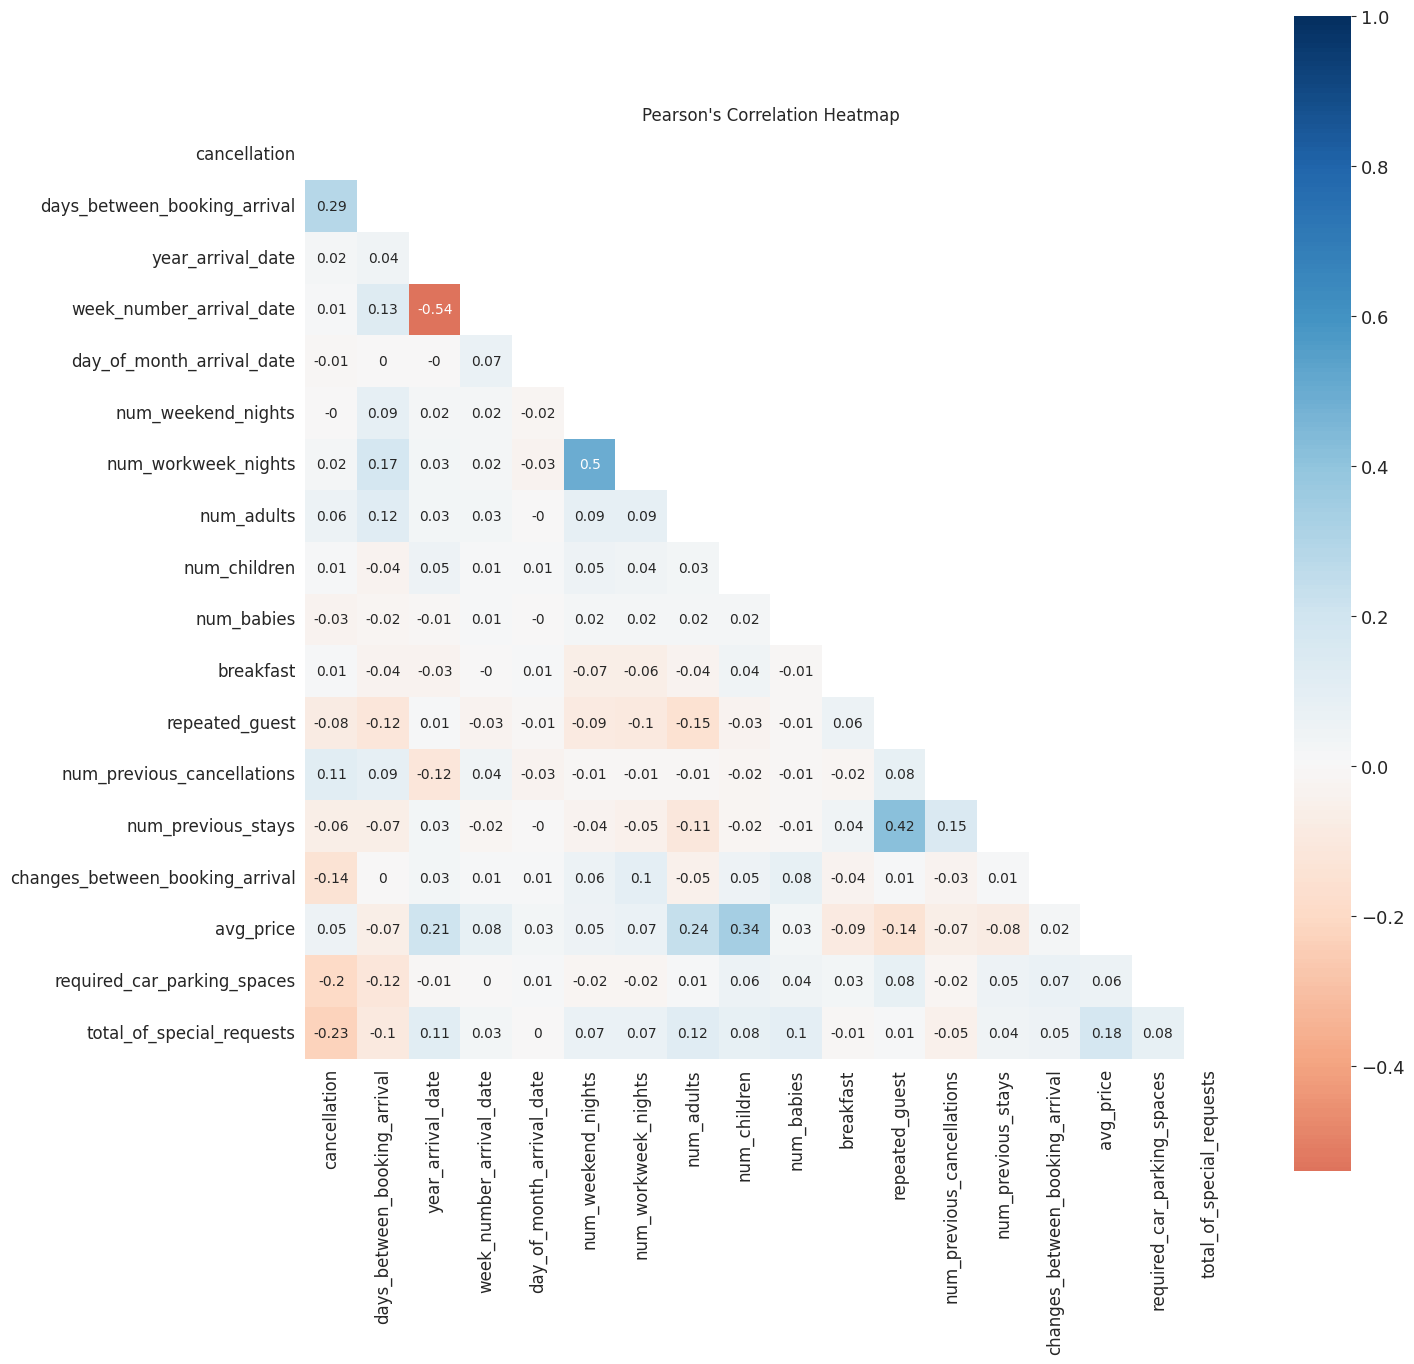

In [16]:
cor = dataset
pear = round(cor.corr(),2)
teste = np.array(pear)
mask = np.zeros_like(pear)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(pear, mask=mask, vmax=1, square=True,center=0,annot=True,annot_kws={"fontsize":10}, cmap="RdBu")
    plt.title('''Pearson's Correlation Heatmap''',fontsize = 12)
    plt.xticks(fontsize=12,rotation=90)
    plt.yticks(fontsize=12,rotation=0)
    cax = plt.gcf().axes[-1] #Fontsize of the right y axis
    cax.tick_params(labelsize=13) #Fontsize of the right y axis

**Observation**:Here we can observe that the most correlation with the **cancellation** variable is **days between booking and arrival**. We will see that interaction in the next section with the histograms.

*There are other variables that exhibit moderate to high correlations, but they are not important for our objectives at this time.

##**Histograms for more insights**

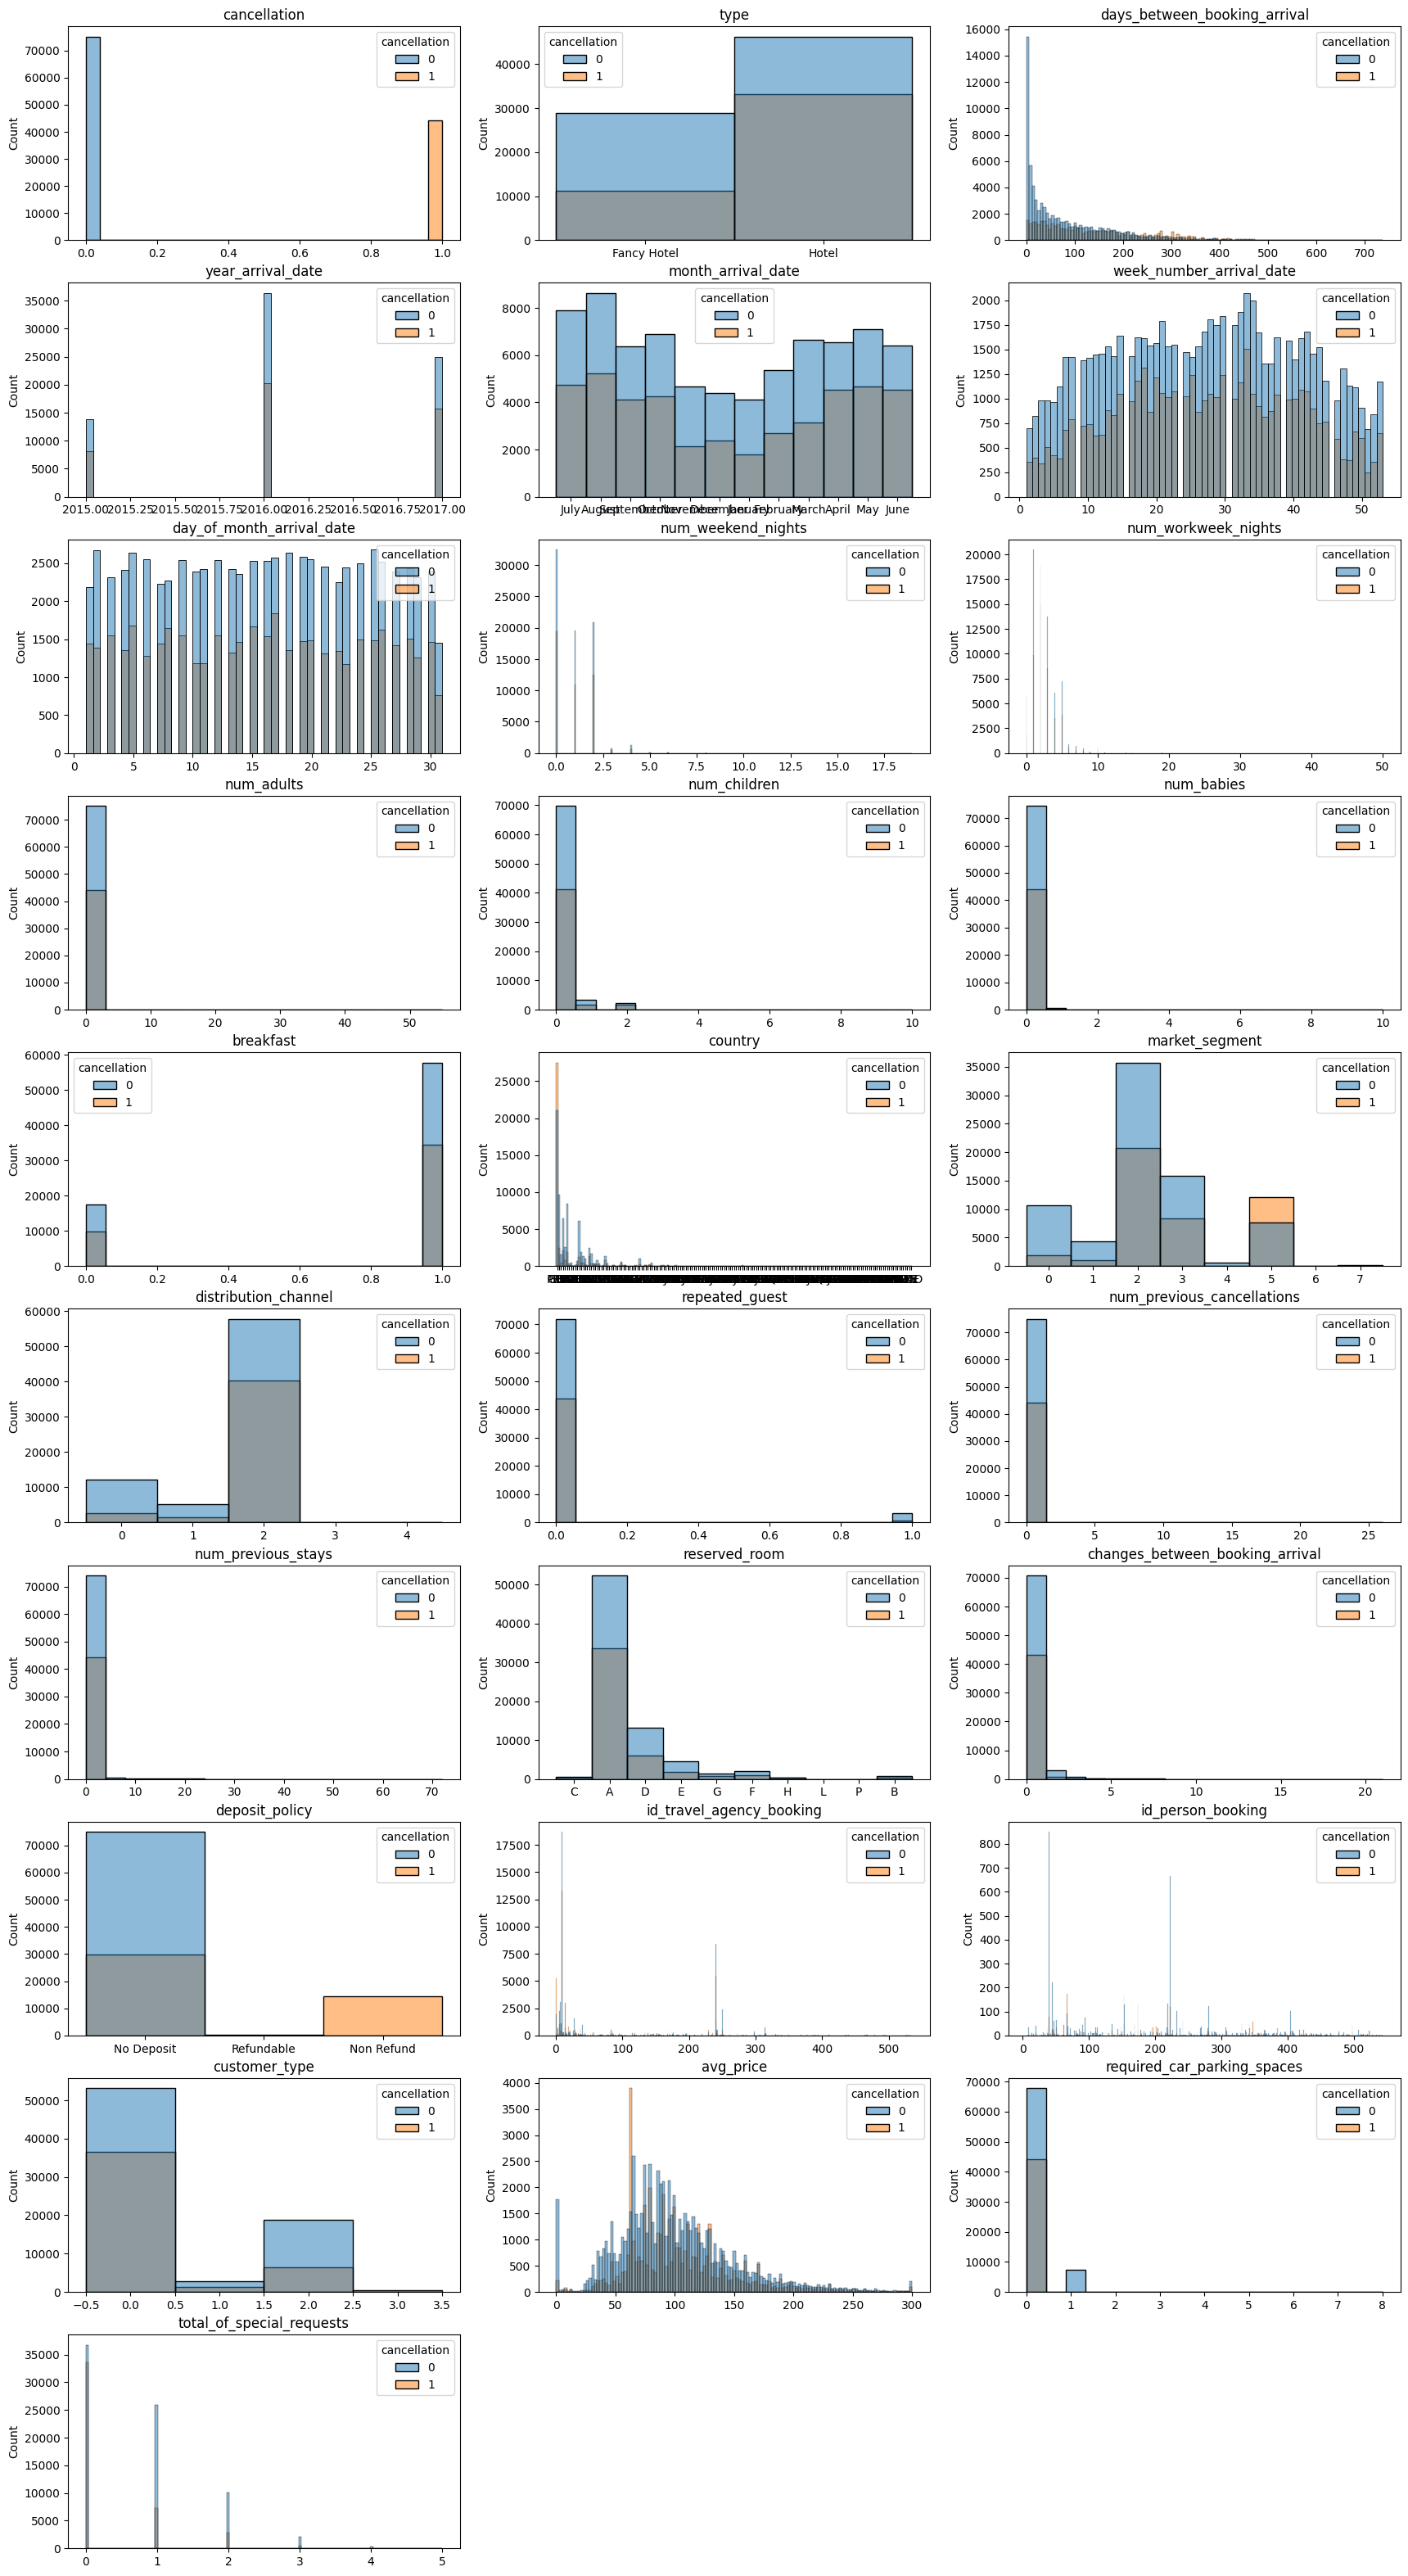

In [17]:
#Histogram
figx,figy=7,4 #subplot size
column = 3 #nº of columns in the figure
lines = 10 #nº of lines in the figure
f, axs = plt.subplots(figx, figy,figsize=(column*figx,lines*figy))
for i,col in enumerate(dataset.columns):
    plt.subplot(10, 3, i+1)
    sns.histplot(dataset,x=col,hue='cancellation')
    plt.title(col)
    plt.xlabel('')

**Observation**: Most of the variables overlap concerning the target variable, roughly following their natural proportions (63% no cancellation / 37% cancellation, as mentioned above). However, some variables are not strictly adhering to this proportion:

- **deposit_policy**
- **market_segment**
- **days_between_booking_arrival**
- **avg_price**
- **country**

Lets see some of them.

#**Question A** - Hypothesis from exploratory analysis

##**Variables that attract attention**

###**Deposity policy**

deposit_policy percentage when cancellation = 0
No Deposit    99.708645
Refundable     0.167629
Non Refund     0.123726
Name: deposit_policy, dtype: float64

deposit_policy percentage when cancellation = 1
No Deposit    67.144537
Non Refund    32.774059
Refundable     0.081404
Name: deposit_policy, dtype: float64


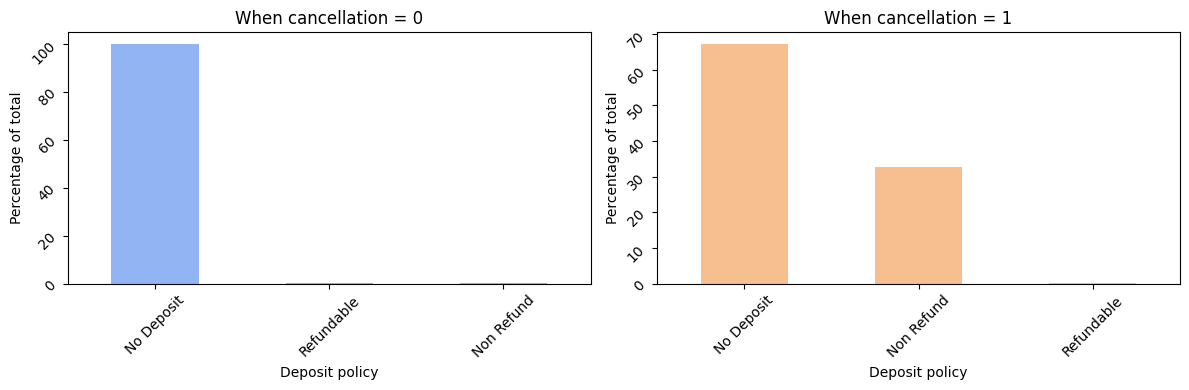

In [18]:
dp0 = dataset['deposit_policy'][dataset['cancellation']==0].value_counts()/dataset['deposit_policy'][dataset['cancellation']==0].value_counts().sum()*100
dp1 = dataset['deposit_policy'][dataset['cancellation']==1].value_counts()/dataset['deposit_policy'][dataset['cancellation']==1].value_counts().sum()*100

print(f'deposit_policy percentage when cancellation = 0\n{dp0}\n')
print(f'deposit_policy percentage when cancellation = 1\n{dp1}')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot for cancellation = 0 with color 'cornflowerblue'
dp0.plot(kind='bar', ax=axs[0], color='cornflowerblue',alpha=0.7)
axs[0].set_title("When cancellation = 0")
axs[0].set_xlabel("Deposit policy")
axs[0].set_ylabel("Percentage of total")
axs[0].tick_params(rotation=45)

# Plot for cancellation = 1 with color 'sandybrown'
dp1.plot(kind='bar', ax=axs[1], color='sandybrown',alpha=0.7)
axs[1].set_title("When cancellation = 1")
axs[1].set_xlabel("Deposit policy")
axs[1].set_ylabel("Percentage of total")
axs[1].tick_params(rotation=45)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Here, we observe that when there are no cancellations, the vast majority of deposit policies are 'No Deposit.' However, when cancellations occur, the deposit policies shift to 'Non-Refundable'.

This could mean that **hotels are mitigating some loss when cancellations occur. Nevertheless, there are likely strategies in place to prevent cancellations** even when the deposit policy is 'No Deposit'.

###**Market segment**

market_segment percentage when cancellation = 0
2    47.55
3    21.16
0    14.20
5    10.26
1     5.72
4     0.86
7     0.25
6     0.00
Name: market_segment, dtype: float64

market_segment percentage when cancellation = 1
2    46.90
5    27.35
3    18.79
0     4.37
1     2.24
4     0.22
7     0.12
6     0.00
Name: market_segment, dtype: float64


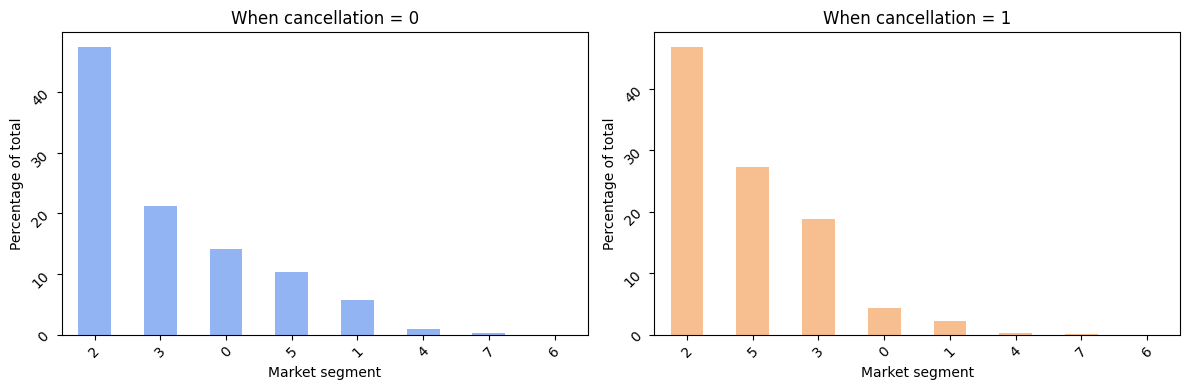

In [19]:
dp0 = dataset['market_segment'][dataset['cancellation']==0].value_counts()/dataset['market_segment'][dataset['cancellation']==0].value_counts().sum()*100
dp1 = dataset['market_segment'][dataset['cancellation']==1].value_counts()/dataset['market_segment'][dataset['cancellation']==1].value_counts().sum()*100

print(f'market_segment percentage when cancellation = 0\n{round(dp0,2)}\n')
print(f'market_segment percentage when cancellation = 1\n{round(dp1,2)}')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot for cancellation = 0 with color 'cornflowerblue'
dp0.plot(kind='bar', ax=axs[0], color='cornflowerblue',alpha=0.7)
axs[0].set_title("When cancellation = 0")
axs[0].set_xlabel("Market segment")
axs[0].set_ylabel("Percentage of total")
axs[0].tick_params(rotation=45)

# Plot for cancellation = 1 with color 'sandybrown'
dp1.plot(kind='bar', ax=axs[1], color='sandybrown',alpha=0.7)
axs[1].set_title("When cancellation = 1")
axs[1].set_xlabel("Market segment")
axs[1].set_ylabel("Percentage of total")
axs[1].tick_params(rotation=45)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Market segments enable a hotel to target diverse consumer groups, tailoring offers to meet their varying needs, preferences, budget levels, and price sensitivity.

The basic 5 market segment is this:

- **Transient:** Business or leisure travelers, often booking directly or through OTAs.
- **Corporate Negotiated:** Business travelers from companies with negotiated accounts.
- **Group:** Guests with pre-reserved rooms, often part of larger groups.
- **Wholesale:** Travelers booking through wholesalers with negotiated rates.
- **Other:** Independent travelers not fitting into specific categories.

We can observe in the graphs and table above that segment 2, 3 and 0 dominate and may represent the most common and significant sources of bookings, regardless of cancellation status.

**Segment 5 might have characteristics or factors that contribute to a higher likelihood of cancellations**. Investigate if Segment 5 consists of a specific type of traveler or booking condition that results in a higher cancellation rate.


###**Days between booking and arrival**

Once this variable is discrete, we can perform some statistical tests!
Let's check the variable's distribution to choose between parametric or non-parametric tests

Shapiro-Wilk Statistic: 0.8567903637886047
P-value: 0.0


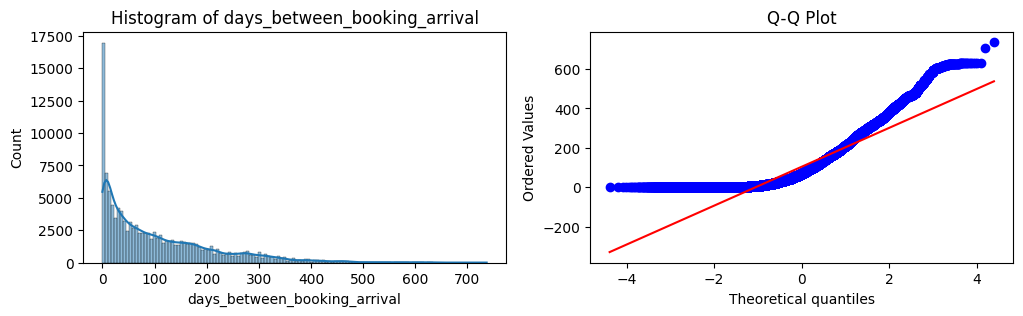

In [20]:
# Extract the variable of interest
days_between_booking_arrival = dataset['days_between_booking_arrival']

# Shapiro-Wilk test for normality
statistic, p_value = shapiro(days_between_booking_arrival)

print(f"Shapiro-Wilk Statistic: {statistic}")
print(f"P-value: {p_value}")

# Visualize the distribution using a histogram and a Q-Q plot
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.histplot(days_between_booking_arrival, kde=True)
plt.title('Histogram of days_between_booking_arrival')

plt.subplot(1, 2, 2)
stats.probplot(days_between_booking_arrival, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.show()

**The data is clearly not normal. So, non-parametric it is.**

I chose Mann-Whitney U to compare the 2 groups:

**Mann-Whitney U Test**

**Use Case:** Compares two independent groups to assess if their distributions are different.


**Assumption:** Assumes independent observations and is often used for non-normally distributed data.

When cancallation == 0:
       days_between_booking_arrival
count                      75166.00
mean                          79.98
std                           91.11
min                            0.00
25%                            9.00
50%                           45.00
75%                          124.00
max                          737.00

When cancallation == 1:
       days_between_booking_arrival
count                      44224.00
mean                         144.85
std                          118.62
min                            0.00
25%                           48.00
50%                          113.00
75%                          214.00
max                          629.00

Mann-Whitney U Statistic: 1032954917.5
P-value: 0.0
The difference is statistically significant.


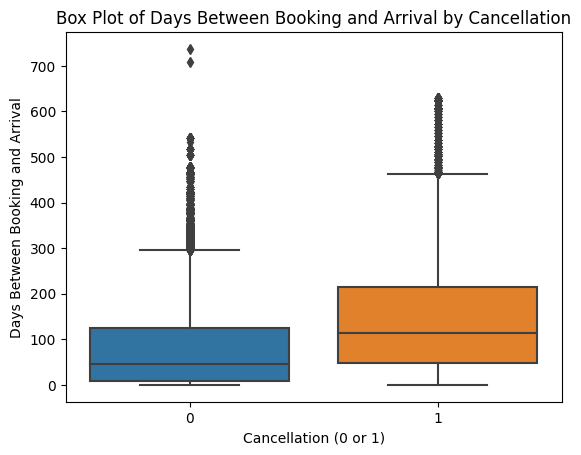

In [21]:
# Extract the two groups for the test
group_0 = dataset[dataset['cancellation'] == 0]['days_between_booking_arrival']
group_1 = dataset[dataset['cancellation'] == 1]['days_between_booking_arrival']

print(f"When cancallation == 0:\n{pd.DataFrame(round(group_0.describe(),2))}\n")
print(f"When cancallation == 1:\n{pd.DataFrame(round(group_1.describe(),2))}\n")

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_0, group_1)

# Print the results
print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check for significance based on the p-value
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("There is no statistically significant difference.")

sns.boxplot(x='cancellation', y='days_between_booking_arrival', data=dataset)
plt.xlabel('Cancellation (0 or 1)')
plt.ylabel('Days Between Booking and Arrival')
plt.title('Box Plot of Days Between Booking and Arrival by Cancellation')
plt.show()

The descriptive statistics and Mann-Whitney U test results suggest a significant difference in the distribution of days between booking and arrival for cancellations (0) and cancellations (1). The median and mean values are notably higher for cancellations (1), indicating that, on average, **people who canceled tended to book further in advance** compared to those who did not cancel. The Mann-Whitney U test confirms the statistical significance of this difference.

###**Country**

In [22]:
ct0 = dataset[dataset['cancellation']==0]['country'].value_counts().head(15)/dataset[dataset['cancellation']==0]['country'].value_counts().sum()*100
ct1 = dataset[dataset['cancellation']==1]['country'].value_counts().head(15)/dataset[dataset['cancellation']==1]['country'].value_counts().sum()*100

#print(f'top 15 countries when cancellation ocurs:\n{pd.DataFrame(ct0)}\n')
#print(f'top 15 countries when cancellation NOT ocurs:\n{pd.DataFrame(ct1)}')

#Here I ommited the code to show in markdown for personal choice
#I also brought the ISO 3166-1 alpha-3 code for better visualization of countries names

| Rank | Cancellation = 0 | Country (Code) | Percentage (%) |    | Rank | Cancellation = 1 | Country (Code) | Percentage (%) |
|------|-------------------|-----------------|-----------------|----|------|-------------------|-----------------|-----------------|
| 1    | ✓                 | Portugal (PRT) | 28.19           |    | 1    | ✓                 | Portugal (PRT) | 62.32           |
| 2    | ✓                 | UK (GBR)        | 12.95           |    | 2    | ✓                 | UK (GBR)        | 5.56            |
| 3    | ✓                 | France (FRA)    | 11.35           |    | 3    | ✓                 | Spain (ESP)     | 4.93            |
| 4    | ✓                 | Spain (ESP)     | 8.55            |    | 4    | ✓                 | France (FRA)    | 4.38            |
| 5    | ✓                 | Germany (DEU)   | 8.12            |    | 5    | ✓                 | Italy (ITA)     | 3.02            |
| 6    | ✓                 | Ireland (IRL)   | 3.40            |    | 6    | ✓                 | Germany (DEU)   | 2.76            |
| 7    | ✓                 | Italy (ITA)     | 3.26            |    | 7    | ✓                 | Ireland (IRL)   | 1.88            |
| 8    | ✓                 | Belgium (BEL)   | 2.50            |    | 8    | ✓                 | Brazil (BRA)    | 1.88            |
| 9    | ✓                 | Netherlands (NLD) | 2.30         |    | 9    | ✓                 | USA (USA)       | 1.13            |
| 10   | ✓                 | USA (USA)       | 2.14            |    | 10   | ✓                 | Belgium (BEL)   | 1.07            |
| 11   | ✓                 | Brazil (BRA)    | 1.87            |    | 11   | ✓                 | China (CHN)     | 1.05            |
| 12   | ✓                 | Switzerland (CHE) | 1.74        |    | 12   | ✓                 | Switzerland (CHE) | 0.97         |
| 13   | ✓                 | Austria (AUT)   | 1.38            |    | 13   | ✓                 | Netherlands (NLD) | 0.88         |
| 14   | ✓                 | China (CN)      | 1.37            |    | 14   | ✓                 | China (CN)      | 0.58            |
| 15   | ✓                 | Sweden (SWE)    | 1.07            |    | 15   |                   | Russia (RUS)    | 0.54            |
|      | ✓                 |                 | 90.17           |    |      | ✓                 |                 | 92.94           |


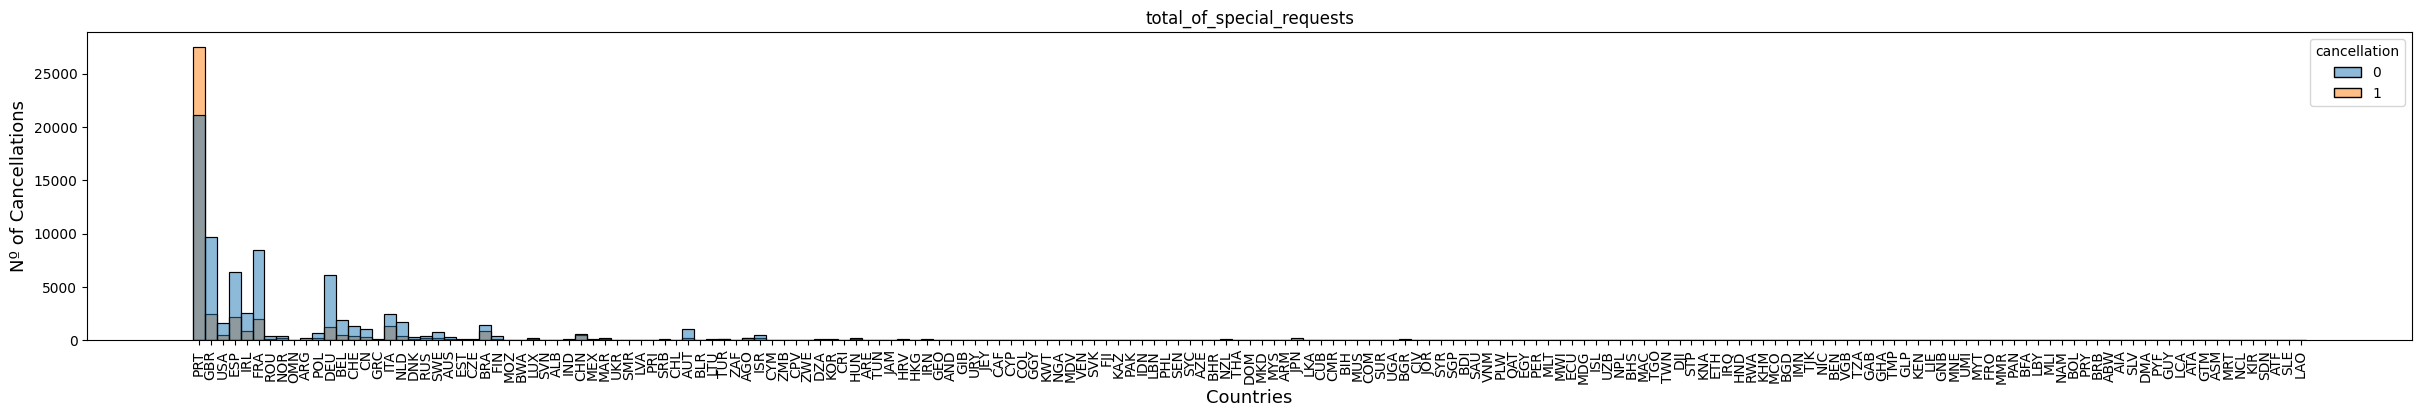

In [23]:
#Histogram
plt.figure(figsize=(30,4))
sns.histplot(dataset,x=dataset['country'],hue='cancellation')
plt.title(col)
plt.xlabel('Countries',fontsize=13)
plt.ylabel('Nº of Cancellations',fontsize=13)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The majority of bookings come from Portugal (PRT), followed by other European countries. Additionally, Portugal dominates cancellations, constituting a significant percentage, while the distribution of cancellations is more spread out across various countries.

**We can see that there is room for improvement in this country in order to prevent cancellations**, maybe even by adopting strategies used by hotels in other countries.

#**Question B** - Model development and evaluation

#**Classification model** - Gradient Boosting algorithm

Below, I've **removed** the '**id_travel_agency_booking**' and '**id_person_booking**' from the model because they aren't influential and also contain several NaN values that don't work with this algorithm.

In [15]:
# Filter dataset to include only rows where 'country' is not NaN
filtered_dataset = dataset.dropna(subset=['country'])

# Extract predictor variables (X) and target variable (y) from the filtered dataset
X = filtered_dataset.drop(['cancellation', 'id_travel_agency_booking', 'id_person_booking'], axis=1)
y = filtered_dataset['cancellation']

# Splitting the data into train and test sets while preserving the proportion of each taxon
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [16]:
#categorical features
cat_features=[
'type',
'breakfast',
'country',
'market_segment',
'distribution_channel',
'repeated_guest',
'reserved_room',
'deposit_policy',
'month_arrival_date',
'customer_type',]

# Defining the CatBoost classifier
catboost_model = CatBoostClassifier(
                          logging_level='Silent',
                          iterations=400,
                          learning_rate=0.01,
                          l2_leaf_reg=0.5,
                          depth=10,
                          random_seed=123,
                          cat_features=cat_features)

In [27]:
# Performing cross-validation
cross_val_scores = cross_val_score(catboost_model, X_train, y_train, cv=3, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean CV Score:", cross_val_scores.mean())
print("Standard Deviation of CV Scores:", cross_val_scores.std())

Cross-Validation Scores: [0.85982555 0.85838379 0.85509858]
Mean CV Score: 0.8577693086623345
Standard Deviation of CV Scores: 0.0019780871258757464


**Here we can observe that the model is quite good, achieving an accuracy of 85% in each fold in the validation set**

In [27]:
#fit the model
catboost_model.fit(X_train,y_train,eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

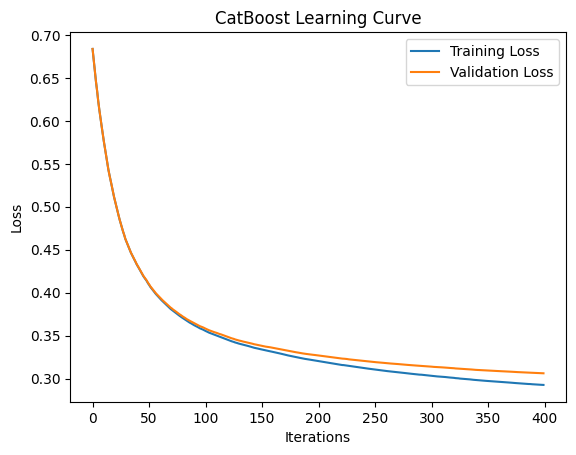

In [28]:
# Get learning curve results
eval_results = catboost_model.get_evals_result()

# Extract training and validation loss values
train_loss = eval_results['learn']
validation_loss = eval_results['validation']

# Plot learning curve
plt.plot(pd.DataFrame(train_loss), label='Training Loss')
plt.plot(pd.DataFrame(validation_loss), label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.show()

We can observe that additional iterations will simply consume computational resources. The model is not learning anymore with more iterations

##Saving and loading the model to avoid re-training in the future

In [20]:
#saving the model
joblib.dump(catboost_model, 'catboost_no_timeseries.pkl')
#downloading it
files.download('catboost_no_timeseries.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
#load the model
catboost_model = joblib.load('catboost_no_timeseries.pkl')

##Evaluation

In [26]:
prediction_train = catboost_model.predict(X_train)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(y_train, prediction_train)
print("Best Model Accuracy - train:", accuracy)

prediction_test = catboost_model.predict(X_test)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(y_test, prediction_test)
print("Best Model Accuracy - test:", accuracy)

Best Model Accuracy - train: 0.8655308719107063
Best Model Accuracy - test: 0.8602506237559923


**The model predicted very well the test set**

In [30]:
# Predict probabilities for the positive class
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

# Threshold list for F1-score vs Threshold Chart
threshold_list = np.arange(0.1, 1, 0.05)

f1_scores = []
accuracies = []

for threshold in threshold_list:
    y_test_pred = (y_pred_prob > threshold).astype(int)
    f1_score = metrics.f1_score(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

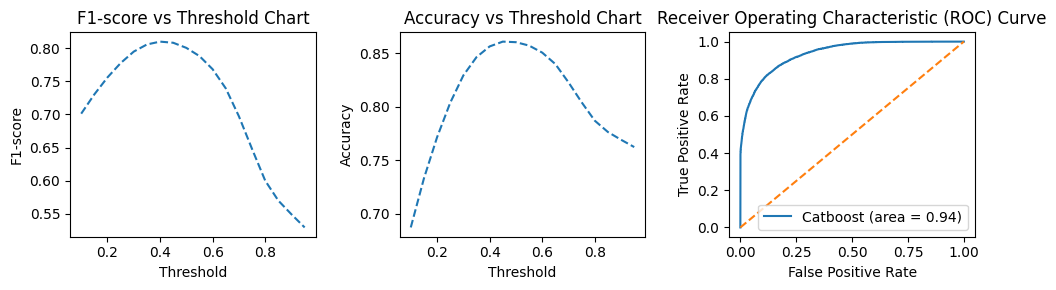

Best threshold for F1-score: 0.4
Best threshold for accuracy: 0.45
Acuracy of the model for best F1-score threshold: 85.63%
Acuracy of the model for best accuracy threshold: 86.08%


In [31]:
# Create a figure and three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Plot F1-score vs Threshold Chart
axes[0].plot(threshold_list, f1_scores, "--")
axes[0].set_title("F1-score vs Threshold Chart")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1-score")

# Plot Accuracy vs Threshold Chart
axes[1].plot(threshold_list, accuracies, "--")
axes[1].set_title("Accuracy vs Threshold Chart")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Accuracy")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[2].plot(fpr, tpr, label=f'Catboost (area = {roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], '--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[2].legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

# Threshold selection
f1_threshold = threshold_list[np.argmax(f1_scores)]
accuracy_threshold = threshold_list[np.argmax(accuracies)]

print('Best threshold for F1-score:', round(f1_threshold,2))
print('Best threshold for accuracy:', round(accuracy_threshold,2))

# Model evaluation with selected thresholds
y_pred_f1 = (y_pred_prob > f1_threshold).astype(int)
y_pred_accuracy = (y_pred_prob > accuracy_threshold).astype(int)

print(f"Acuracy of the model for best F1-score threshold: {accuracy_score(y_test, y_pred_f1)*100:.2f}%")
print(f"Acuracy of the model for best accuracy threshold: {accuracy_score(y_test, y_pred_accuracy)*100:.2f}%")

I used the F1-score, because the classes are unbalanced and F1 provides a balanced measure of performance by considering both precision and recall. In scenarios with imbalanced classes, accuracy alone can be misleading, as it may be high simply because the model predicts the majority class well, while ignoring the minority class. F1 score considers both false positives and false negatives, making it a more reliable metric for evaluating model performance when class distributions are uneven.

##Confusion matrix

              precision    recall  f1-score   support

           0     0.8847    0.8973    0.8910     22424
           1     0.8219    0.8021    0.8118     13247

    accuracy                         0.8619     35671
   macro avg     0.8533    0.8497    0.8514     35671
weighted avg     0.8614    0.8619    0.8616     35671



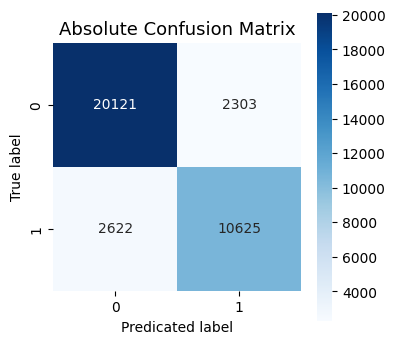

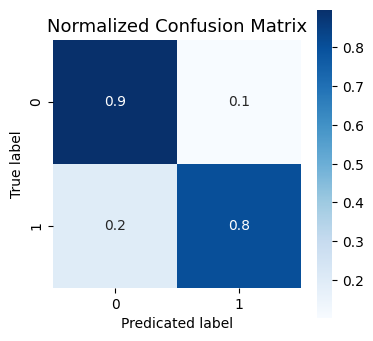

In [33]:
#classification report
print(metrics.classification_report(y_test,y_pred_f1,digits=4))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_pred_f1)
df_cm = pd.DataFrame(cm)

plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Absolute Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

cm = confusion_matrix(y_test, y_pred_f1,normalize='true')
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()


**Conclusion**: The model performs well in predicting non-cancellations (class 0) with high precision, recall, and F1-score. However, its performance in predicting cancellations (class 1) is slightly lower, as evidenced by lower precision, recall, and F1-score. Overall, the model's accuracy is reasonable, but there is room for improvement in predicting cancellations to meet the objective of anticipating and preventing them effectively.

Additionally, further exploration of the models and their hyperparameters is necessary to optimize performance and better predict cancellations.

Exploring the SHAP library could provide valuable insights, particularly since we utilized a tree-based algorithm that lends itself to explanation.

#**Classification model - with SMOTE** - Gradient Boosting algorithm

We checked the distribution of labels (cancellation and no cancellation) in the samples and concluded that the dataset was imbalanced, which could potentially impact the model's performance. To address this issue, we employed the *Synthetic Minority Over-sampling Technique for Nominal and Continuous* (**SMOTENC**) to oversample the data and achieve a balanced set.

The technique works by creating synthetic samples for classes with fewer samples, randomly choosing one of the k nearest neighbors to generate similar, adjusted samples. We used 5 nearest neighbors (standard parameter) as the parameter k, resulting in a balanced training set with 104642 samples, with 52321 samples for each class.

In [34]:
# Filter dataset to include only rows where 'country' is not NaN
filtered_dataset = dataset.dropna(subset=['country'])
filtered_dataset = filtered_dataset.dropna(subset=['num_children'])

# Extract predictor variables (X) and target variable (y) from the filtered dataset
X = filtered_dataset.drop(['cancellation', 'id_travel_agency_booking', 'id_person_booking'], axis=1)
y = filtered_dataset['cancellation']

X.loc[X['type'] == 'Fancy Hotel', 'type'] = 1
X.loc[X['type'] == 'Hotel', 'type'] = 0

# Splitting the data into train and test sets while preserving the proportion of each taxon
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [ ]:
# Filter dataset to include only rows where 'country' is not NaN
filtered_dataset = dataset.dropna(subset=['country'])
filtered_dataset = filtered_dataset.dropna(subset=['num_children'])

# Extract predictor variables (X) and target variable (y) from the filtered dataset
X = filtered_dataset.drop(['cancellation', 'id_travel_agency_booking', 'id_person_booking'], axis=1)
y = filtered_dataset['cancellation']

X.loc[X['type'] == 'Fancy Hotel', 'type'] = 1
X.loc[X['type'] == 'Hotel', 'type'] = 0

# Identify categorical columns
categorical_cols = ['type', 'breakfast', 'country', 'market_segment', 'distribution_channel', 'repeated_guest', 'reserved_room', 'deposit_policy', 'month_arrival_date', 'customer_type']

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

# Combine encoded categorical features with numerical features
X_processed = np.hstack((X_encoded, X.drop(columns=categorical_cols).values))

# Splitting the data into train and test sets while preserving the proportion of each taxon
X_train_processed, X_test_processed, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.3)

In [51]:
# Apply SMOTENC to the processed data
os = SMOTENC(categorical_features=list(range(len(categorical_cols))), random_state=0)
os_X_train, os_y_train = os.fit_resample(X_train_processed, y_train)


length of training data is  118898
length of oversampled training data is  104642 

Number of samples in No cancellation 52321
Proportion of samples in No cancellation 0.5
Number of samples in cancellation 52321
Proportion of samples in cancellation 0.5


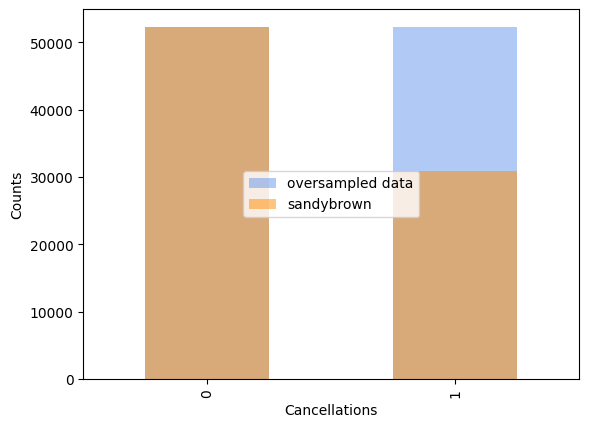

In [52]:
# we can Check the numbers of our data
label = {0 :'No cancellation',1 :'cancellation'}
print("\nlength of training data is ",len(X))
print("length of oversampled training data is ",len(os_X_train),'\n')
for i in range(0,2):
  print(f"Number of samples in {label[i]}",len(os_y_train[os_y_train==i]))
  print(f"Proportion of samples in {label[i]}",len(os_y_train[os_y_train==i])/len(os_X_train))
ax = os_y_train.value_counts().plot(kind='bar',alpha=0.5,color = 'cornflowerblue',label='oversampled data')
y_train.value_counts().plot(kind='bar',alpha=0.5,color = 'darkorange',ax=ax,label='sandybrown')
plt.xlabel('Cancellations')
plt.ylabel('Counts')
plt.legend(loc='center')
plt.show()

In [53]:
#categorical features
# Defining the CatBoost classifier
catboost_model = CatBoostClassifier(
                          logging_level='Silent',
                          iterations=400,
                          learning_rate=0.01,
                          l2_leaf_reg=0.5,
                          depth=10,
                          random_seed=123)

# Performing cross-validation
cross_val_scores = cross_val_score(catboost_model, os_X_train, os_y_train, cv=3, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean CV Score:", cross_val_scores.mean())
print("Standard Deviation of CV Scores:", cross_val_scores.std())

Cross-Validation Scores: [0.82577908 0.86061179 0.91556766]
Mean CV Score: 0.867319510790598
Standard Deviation of CV Scores: 0.03696162432398085


In [54]:
#fit the model
catboost_model.fit(os_X_train,os_y_train,eval_set=(X_test_processed, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

##Evaluation

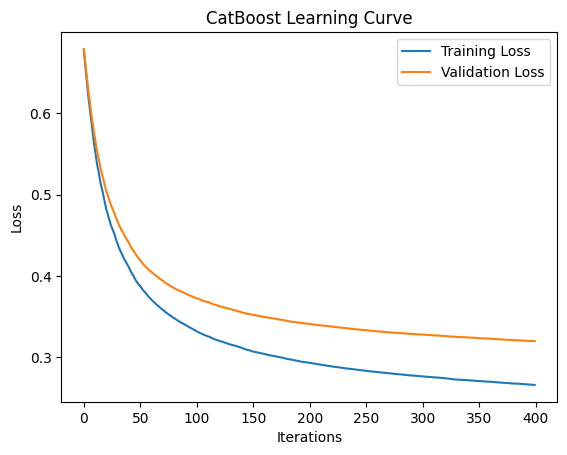

In [55]:
# Get learning curve results
eval_results = catboost_model.get_evals_result()

# Extract training and validation loss values
train_loss = eval_results['learn']
validation_loss = eval_results['validation']

# Plot learning curve
plt.plot(pd.DataFrame(train_loss), label='Training Loss')
plt.plot(pd.DataFrame(validation_loss), label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.show()

In [56]:
prediction_train = catboost_model.predict(os_X_train)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(os_y_train, prediction_train)
print("Best Model Accuracy - train:", accuracy)

prediction_test = catboost_model.predict(X_test_processed)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(y_test, prediction_test)
print("Best Model Accuracy - test:", accuracy)

Best Model Accuracy - train: 0.882723954052866
Best Model Accuracy - test: 0.8525091112980095


In [57]:
# Predict probabilities for the positive class
y_pred_prob = catboost_model.predict_proba(X_test_processed)[:, 1]

# Threshold list for F1-score vs Threshold Chart
threshold_list = np.arange(0.1, 1, 0.05)

f1_scores = []
accuracies = []

for threshold in threshold_list:
    y_test_pred = (y_pred_prob > threshold).astype(int)
    f1_score = metrics.f1_score(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

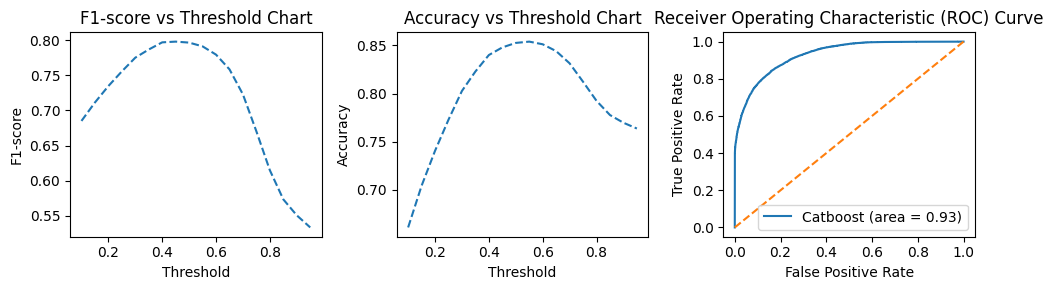

Best threshold for F1-score: 0.45
Best threshold for accuracy: 0.55
Acuracy of the model for best F1-score threshold: 84.79%
Acuracy of the model for best accuracy threshold: 85.39%


In [58]:
# Create a figure and three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Plot F1-score vs Threshold Chart
axes[0].plot(threshold_list, f1_scores, "--")
axes[0].set_title("F1-score vs Threshold Chart")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1-score")

# Plot Accuracy vs Threshold Chart
axes[1].plot(threshold_list, accuracies, "--")
axes[1].set_title("Accuracy vs Threshold Chart")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Accuracy")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[2].plot(fpr, tpr, label=f'Catboost (area = {roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], '--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[2].legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

# Threshold selection
f1_threshold = threshold_list[np.argmax(f1_scores)]
accuracy_threshold = threshold_list[np.argmax(accuracies)]

print('Best threshold for F1-score:', round(f1_threshold,2))
print('Best threshold for accuracy:', round(accuracy_threshold,2))

# Model evaluation with selected thresholds
y_pred_f1 = (y_pred_prob > f1_threshold).astype(int)
y_pred_accuracy = (y_pred_prob > accuracy_threshold).astype(int)

print(f"Acuracy of the model for best F1-score threshold: {accuracy_score(y_test, y_pred_f1)*100:.2f}%")
print(f"Acuracy of the model for best accuracy threshold: {accuracy_score(y_test, y_pred_accuracy)*100:.2f}%")

##Confusion matrix

              precision    recall  f1-score   support

           0     0.8851    0.8711    0.8780     22424
           1     0.7875    0.8085    0.7978     13246

    accuracy                         0.8479     35670
   macro avg     0.8363    0.8398    0.8379     35670
weighted avg     0.8488    0.8479    0.8483     35670



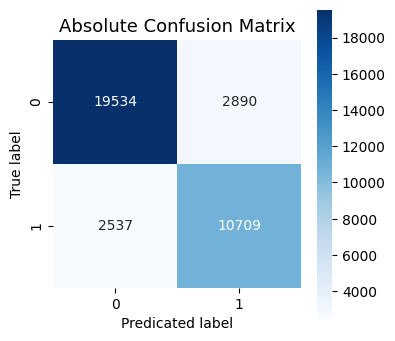

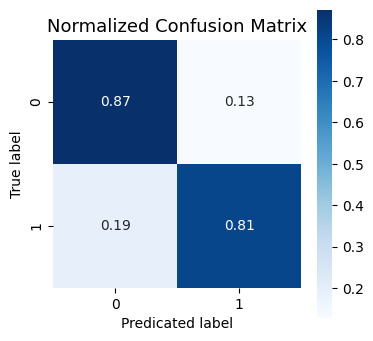

In [59]:
#classification report
print(metrics.classification_report(y_test,y_pred_f1,digits=4))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_pred_f1)
df_cm = pd.DataFrame(cm)

plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Absolute Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

cm = confusion_matrix(y_test, y_pred_f1,normalize='true')
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

**Conclusion**: The model's performance, albeit slightly worse compared to the model without data balancing, did not change drastically. Thus, it seems preferable to retain the initial model that did not incorporate synthetic data.

#**Question C** - Time series in cross-validation

#**Exploring time series**

### Re-loading the data

I did this step to avoid run all the code again

In [32]:
dataset = pd.read_csv('/content/drive/MyDrive/DHAUZ/processo_seletivo/dataset/cancellation_prediction.csv',header=0,sep=',')

# List of columns to convert to categorical
columns_to_convert = ['market_segment', 'distribution_channel', 'id_travel_agency_booking', 'id_person_booking', 'customer_type']

# Convert columns to categorical
dataset[columns_to_convert] = dataset[columns_to_convert].astype('category')

#reordering the dataset
desired_order = ['cancellation', 'type', 'days_between_booking_arrival',
                 'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
                 'day_of_month_arrival_date', 'num_weekend_nights',
                 'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
                 'breakfast', 'country', 'market_segment', 'distribution_channel',
                 'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
                 'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
                 'id_travel_agency_booking', 'id_person_booking', 'customer_type',
                 'avg_price', 'required_car_parking_spaces',
                 'total_of_special_requests']

# Reorder the columns
dataset = dataset[desired_order]

# Filter dataset to include only rows where 'country' is not NaN
filtered_dataset = dataset.dropna(subset=['country'])
filtered_dataset = filtered_dataset.drop(['id_travel_agency_booking', 'id_person_booking'], axis=1)

In [73]:
# Define a dictionary to map month names to their corresponding numeric values
month_to_num = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Convert month names to numeric values
filtered_dataset['month_num'] = filtered_dataset['month_arrival_date'].map(month_to_num)

# Concatenate columns into a single string separated by "-"
filtered_dataset['arrival_date'] = filtered_dataset['year_arrival_date'].astype(str) + '-' + filtered_dataset['month_num'].astype(str) + '-' + filtered_dataset['day_of_month_arrival_date'].astype(str)

# Convert the concatenated string to datetime format
filtered_dataset['arrival_date'] = pd.to_datetime(filtered_dataset['arrival_date'])

# Format the variable as a date
filtered_dataset['arrival_date'] = filtered_dataset['arrival_date'].dt.date

# Sort the dataset by a temporal feature (e.g., arrival_date_year, reservation_status_date)
filtered_dataset_sorted = filtered_dataset.sort_values(by='arrival_date')

# Define the features and target variable
X = filtered_dataset_sorted.drop(columns=['cancellation','arrival_date'])
y = filtered_dataset_sorted['cancellation']

**Here we going to use Time Series Split to preserve the time structure.
Below we can see a figure showing how it works:**

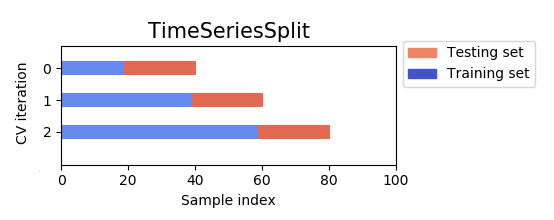

In [120]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
i = 1
#check data split lengths:
for train_index, test_index in tscv.split(X):
    print(f'fold {i}')
    print(f'length of train set: {len(X.iloc[train_index])}')
    print(f'length of test set: {len(X.iloc[test_index])}\n')
    i+=1

fold 1
length of train set: 29727
length of test set: 29725

fold 2
length of train set: 59452
length of test set: 29725

fold 3
length of train set: 89177
length of test set: 29725



In [48]:
# Initialize lists to store accuracy scores
train_scores = []
test_scores = []

# Define the categorical features
cat_features = ['type', 'month_arrival_date', 'country', 'market_segment', 'distribution_channel', 'reserved_room', 'deposit_policy', 'customer_type']
# Defining the CatBoost classifier
catboost_model = CatBoostClassifier(
                          logging_level='Silent',
                          iterations=400,
                          learning_rate=0.01,
                          l2_leaf_reg=0.5,
                          depth=10,
                          random_seed=123,
                          cat_features=cat_features,
                          )

# Perform TimeSeriesSplit and train the CatBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the CatBoost classifier
    catboost_model.fit(X_train, y_train, cat_features=cat_features)

    # Predictions
    y_train_pred = catboost_model.predict(X_train)
    y_test_pred = catboost_model.predict(X_test)

    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracy scores to lists
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Calculate mean accuracy scores
mean_train_accuracy = sum(train_scores) / len(train_scores)
mean_test_accuracy = sum(test_scores) / len(test_scores)

print("Mean Train Accuracy:", mean_train_accuracy)
print("Mean Test Accuracy:", mean_test_accuracy)


Mean Train Accuracy: 0.9069747617077996
Mean Test Accuracy: 0.7931370899915896


##Saving and loading the model to avoid re-training in the future

In [49]:
#saving the model
joblib.dump(catboost_model, 'catboost_timeseries.pkl')
#downloading it
files.download('catboost_timeseries.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#load the model
catboost_model = joblib.load('catboost_no_timeseries.pkl')

##Evaluation

In [50]:
prediction_train = catboost_model.predict(X_train)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(y_train, prediction_train)
print("Best Model Accuracy - train:", accuracy)

prediction_test = catboost_model.predict(X_test)
# Evaluating the accuracy of the best model
accuracy = accuracy_score(y_test, prediction_test)
print("Best Model Accuracy - test:", accuracy)

Best Model Accuracy - train: 0.8837592652814067
Best Model Accuracy - test: 0.7850294365012616


In [51]:
# Predict probabilities for the positive class
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

# Threshold list for F1-score vs Threshold Chart
threshold_list = np.arange(0.1, 1, 0.05)

f1_scores = []
accuracies = []

for threshold in threshold_list:
    y_test_pred = (y_pred_prob > threshold).astype(int)
    f1_score = metrics.f1_score(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

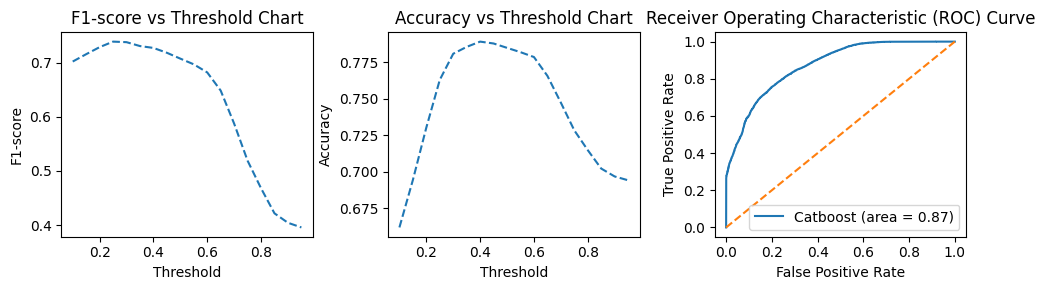

Best threshold for F1-score: 0.25
Best threshold for accuracy: 0.4
Acuracy of the model for best F1-score threshold: 76.31%
Acuracy of the model for best accuracy threshold: 78.93%


In [52]:
# Create a figure and three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Plot F1-score vs Threshold Chart
axes[0].plot(threshold_list, f1_scores, "--")
axes[0].set_title("F1-score vs Threshold Chart")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1-score")

# Plot Accuracy vs Threshold Chart
axes[1].plot(threshold_list, accuracies, "--")
axes[1].set_title("Accuracy vs Threshold Chart")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Accuracy")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[2].plot(fpr, tpr, label=f'Catboost (area = {roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], '--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[2].legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

# Threshold selection
f1_threshold = threshold_list[np.argmax(f1_scores)]
accuracy_threshold = threshold_list[np.argmax(accuracies)]

print('Best threshold for F1-score:', round(f1_threshold,2))
print('Best threshold for accuracy:', round(accuracy_threshold,2))

# Model evaluation with selected thresholds
y_pred_f1 = (y_pred_prob > f1_threshold).astype(int)
y_pred_accuracy = (y_pred_prob > accuracy_threshold).astype(int)

print(f"Acuracy of the model for best F1-score threshold: {accuracy_score(y_test, y_pred_f1)*100:.2f}%")
print(f"Acuracy of the model for best accuracy threshold: {accuracy_score(y_test, y_pred_accuracy)*100:.2f}%")

I used the F1-score, because the classes are unbalanced and F1 provides a balanced measure of performance by considering both precision and recall. In scenarios with imbalanced classes, accuracy alone can be misleading, as it may be high simply because the model predicts the majority class well, while ignoring the minority class. F1 score considers both false positives and false negatives, making it a more reliable metric for evaluating model performance when class distributions are uneven.

##Confusion matrix

              precision    recall  f1-score   support

           0     0.8584    0.7199    0.7831     17660
           1     0.6684    0.8262    0.7389     12065

    accuracy                         0.7631     29725
   macro avg     0.7634    0.7731    0.7610     29725
weighted avg     0.7813    0.7631    0.7652     29725



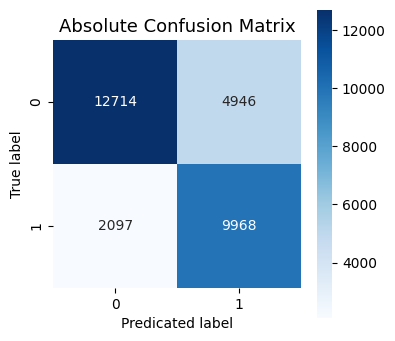

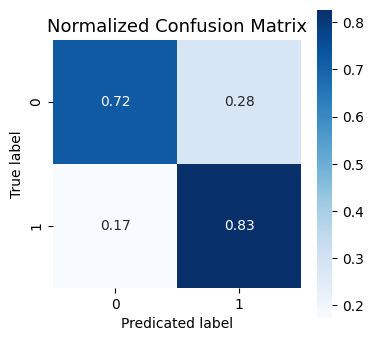

In [53]:
#classification report
print(metrics.classification_report(y_test,y_pred_f1,digits=4))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_pred_f1)
df_cm = pd.DataFrame(cm)

plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Absolute Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

cm = confusion_matrix(y_test, y_pred_f1,normalize='true')
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 13)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()


**Conclusion**: When performing cross-validation of a classification model, it's essential to consider the differences between using random train-test splits and temporal splits. Random train-test splits involve randomly dividing the dataset into training and testing sets, while temporal splits involve dividing the data based on time, such as training on earlier time periods and testing on later ones.

The choice between the two approaches can significantly impact the model's performance and generalization ability (as we observed). Temporal splits are particularly beneficial when dealing with time-dependent data, as they reflect real-world scenarios more accurately and help capture temporal patterns and trends, despite yielding slightly worse results.

I believe this approach is more indicated despite its low performance (more conservative). In the figures below, we can see the patterns we will be missing without a time series.

Additionally, I think it would be interesting to transform this problem into a regression problem to predict the number of cancellations per day, month, or week.


##**Cancellations frequency**

In [ ]:
# Convert 'arrival_date' to datetime format
filtered_dataset_sorted['arrival_date'] = pd.to_datetime(filtered_dataset_sorted['arrival_date'])

# Group by arrival_date and sum cancellations
cancellations_per_day = filtered_dataset_sorted.groupby('arrival_date')['cancellation'].sum().reset_index()

# Group by month and sum cancellations
monthly_cancellations = filtered_dataset_sorted.groupby(filtered_dataset_sorted['arrival_date'].dt.to_period('M'))['cancellation'].sum()

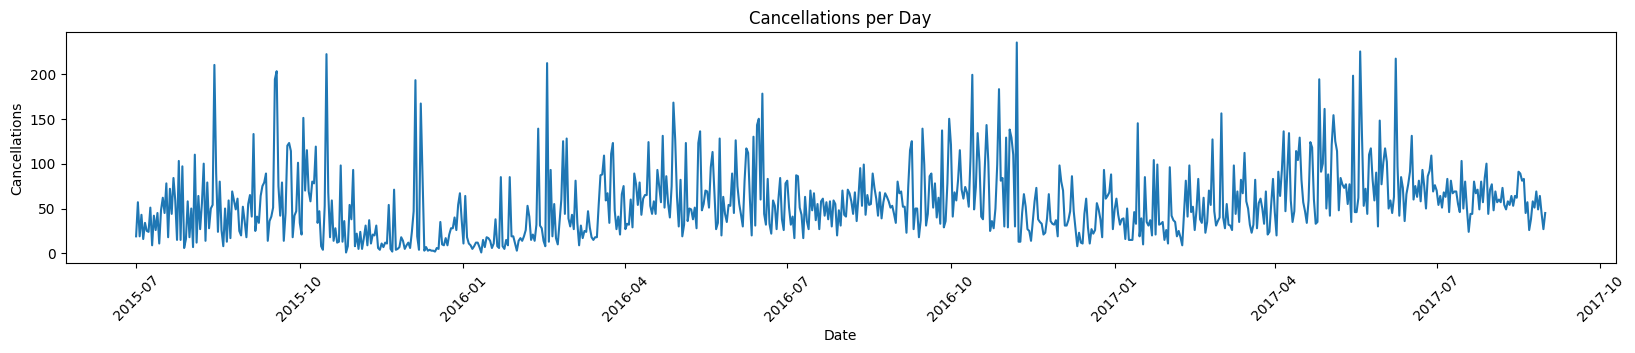

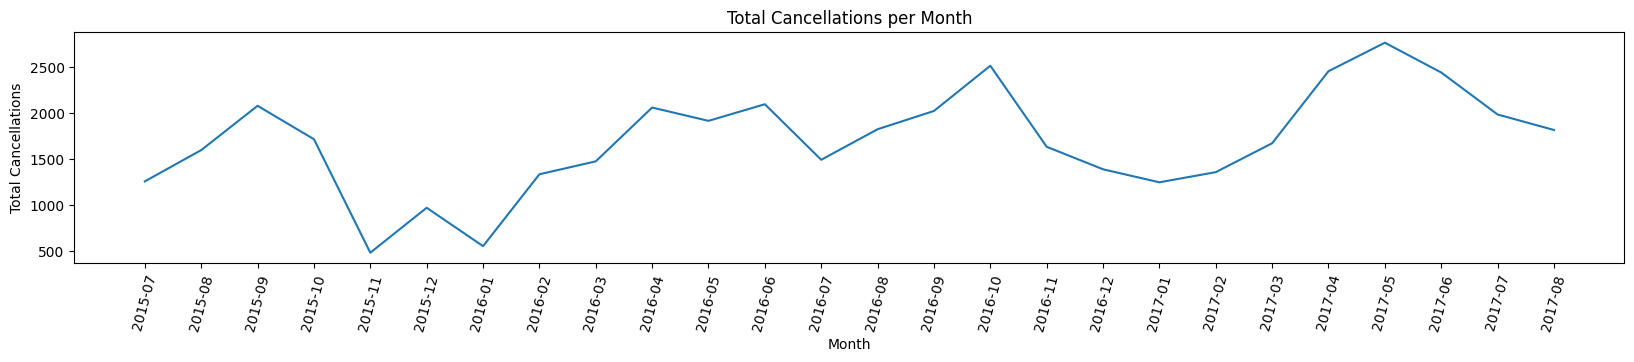

In [109]:
# Set the figure size
plt.figure(figsize=(20, 3))

# Plot the time series
plt.plot(cancellations_per_day['arrival_date'], cancellations_per_day['cancellation'], linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cancellations')
plt.title('Cancellations per Day')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

# Convert Period index to strings representing the month
month_labels = monthly_cancellations.index.strftime('%Y-%m')

# Plotting
plt.figure(figsize=(20,3))
plt.plot(month_labels, monthly_cancellations.values, linestyle='-')
plt.title('Total Cancellations per Month')
plt.xlabel('Month')
plt.ylabel('Total Cancellations')
plt.xticks(rotation=75)
plt.show()